# IBM Analog Hardware Acceleration Kit (AIHWKIT): extending functionality

### Authors: [Malte Rasch](https://www.linkedin.com/in/malte-j-rasch-08731817/)

The AIHWKit is highly configurable and can be easily extended and customized. In this notebook, we show exemplarily how custom functionality can be implemented using the AIHWKit. 

<a href="https://colab.research.google.com/github/IBM/aihwkit/blob/master/notebooks/tutorial/extending_functionality.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

The IBM Analog Hardware Acceleration Kit (AIHWKIT) is an open-source Python toolkit for exploring and using the capabilities of in-memory computing devices (PCM, RRAM and others) in the context of artificial intelligence.
The PyTorch integration consists of a series of primitives and features that allow using the toolkit within PyTorch.

The GitHub repository can be found at: https://github.com/IBM/aihwkit

To learn more about Analog AI and the harware befind it, refer to this webpage: https://aihw-composer.draco.res.ibm.com/about


### Installing the AIHWKIT
The first thing to do is install the AIHWKIT and dependencies in your environment. The preferred way to install this package is by using the Python package index (please uncomment this line to install in your environment if not previously installed):

In [ ]:
# To install the cpu-only enabled kit, un-comment the line below
# %pip install aihwkit

# To install the GPU-enabled wheel go to https://aihwkit.readthedocs.io/en/latest/advanced_install.html#install-the-aihwkit-using-pip
# and copy the option on GPU options that best suits your enviroment and paste it below and run the cell. For example, Python 3.10 and CUDA 12.1:
# !wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.9.2+cuda121-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# %pip install aihwkit-0.9.2+cuda121-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

# Install some prerequisites
%pip install pytorch-lightning pandas


  Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl.metadata (21 kB)
  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached torchmetrics-1.6.1-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.12.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached attrs-25.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1.5.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cach

If the library was installed correctly, you can use the following snippet for creating an analog layer and predicting the output. In the code snippet below AnalogLinear is the Analog equivalent to Linear PyTorch layer.

In [1]:
from torch import Tensor
from aihwkit.nn import AnalogLinear

model = AnalogLinear(2, 2)
model(Tensor([[0.1, 0.2], [0.3, 0.4]]))

tensor([[-0.0727, -0.6387],
        [-0.2327, -0.8269]], grad_fn=<AddBackward0>)

### Helper functions defining an MNIST DNN and a trainer
We first define a simple MNIST network to define a trainer which we use in the section below.  To reduce space and effort,  we here define the training using PyTorch lightning (see the [examples](https://github.com/IBM/aihwkit/tree/master/examples) in the AIHWKIT for a more explicit definition of the training)   


In [2]:
import os
import logging
import matplotlib.pyplot as plt 
from pandas import read_csv

from torch import nn
from torch import argmax
from torch.nn.functional import nll_loss
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
from torchmetrics.functional import accuracy

from aihwkit.optim import AnalogSGD
from aihwkit.nn.conversion import convert_to_analog_mapped

PATH_DATASET = os.path.join('data', 'DATASET')
os.makedirs(PATH_DATASET, exist_ok=True)
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.CRITICAL)


def create_network():
    """Create the neural network using digital layers.
    Returns:
        nn.Module: created analog model
    """

    input_size = 784
    hidden_sizes = [256, 128]
    output_size = 10

    model = nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0], True),
        nn.Sigmoid(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1], True),
        nn.Sigmoid(),
        nn.Linear(hidden_sizes[1], output_size, True),
        nn.LogSoftmax(dim=1)
    )
    return model


class LitAnalogModel(pl.LightningModule):
    def __init__(self, model, rpu_config, lr=0.05):
        super().__init__()

        # We simply convert the given model to analog on-the-fly
        self.analog_model = convert_to_analog_mapped(model, rpu_config)
        self.lr = lr

    def forward(self, x):
        x_reshaped = x.reshape(x.shape[0], -1)
        return self.analog_model(x_reshaped)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nll_loss(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = nll_loss(logits, y)
        preds = argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        # we need to use the analog-aware optimizers
        optimizer = AnalogSGD(
            self.analog_model.parameters(),
            lr=self.lr,
        )
        return optimizer


def get_data_loaders(batch_size=100):
    """Get the data loaders for train from torchvision datasets."""

    train_set = MNIST(PATH_DATASET, download=True, train=True, transform=ToTensor())
    test_set = MNIST(PATH_DATASET, download=True, train=False, transform=ToTensor())
    train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
    test_data = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_data, test_data


def build_trainer(rpu_config, lr=0.1, max_epochs=3, log="1"):
    """Build the lightning model and resurn the trainer"""

    trainer = pl.Trainer(
        enable_model_summary=False,
        logger=pl.loggers.CSVLogger(save_dir=os.path.join("logs", log)),
        callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=10)],
        max_epochs=max_epochs,
    )

    model = LitAnalogModel(lr=lr, rpu_config=rpu_config, model=create_network())
    return trainer, model


def fit_model(trainer, model):
    """Train the model using lightning trainer."""

    trainer.fit(model, *get_data_loaders(batch_size=100))
    trainer.test(model, get_data_loaders(batch_size=100)[1])


def plot_loss(trainer, tstr=''):
    """Plot the train loss for each batch."""
    metrics = read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    metrics.plot("step", "train_loss")
    plt.ylabel("Loss")
    plt.title(tstr)
    return plt.gcf()

## Defining a custom crossbar simulation (SimulatorTile) for the forward pass during inference

Assume that the forward pass of the `TorchInferenceRPUConfig` is not what you want to model as it does not conform with your analog in-memory compute design. For instance, by default it assumes that positive and negative inputs are given in one pass. Instead, let's assume one wants to customize the the forward pass so that the positive and the negative input is given in two separate passes (with separate noises, and non-idealities etc.). One could define a custom simulator tile overloading the forward pass as follows:

In [3]:
from torch import Tensor, clamp
from aihwkit.simulator.tiles.torch_tile import TorchSimulatorTile

class TwoPassTorchSimulatorTile(TorchSimulatorTile):
    """New class where two forward passes are done optionally"""

    def __init__(
        self, x_size: int, d_size: int, rpu_config: "TwoPassTorchInferenceRPUConfig", bias: bool = False
    ):
        super().__init__(x_size, d_size, rpu_config, bias)
        self._one_pass = rpu_config.one_pass  # cannot save rpu_config on SimulatorTile level

    def forward(
        self,
        x_input: Tensor,
        *args, **kwargs,
    ) -> Tensor:

        if self._one_pass:
            return super().forward(x_input, *args, **kwargs)

        x_pos = clamp(x_input, min=0.0)
        x_neg = -clamp(x_input, max=0.0)
        y_pos = super().forward(x_pos, *args, **kwargs)
        y_neg = super().forward(x_neg, *args, **kwargs)

        return y_pos - y_neg


Similarly, other methods of the tile could be overridden, such as the weight noise injections for hardware-aware training (`modify_weight`). A new `rpu_config` for the new simulator tile can be defined as follows. Note that we set the simulator tile varialble to the new tile class we have defined above. This will cause all analog module to instantiate the new class instead of the old. The new parameter `one_class` is interprested by the new tile.  

In [4]:
from typing import ClassVar, Type
from dataclasses import dataclass
from aihwkit.simulator.configs import TorchInferenceRPUConfig

@dataclass
class TwoPassTorchInferenceRPUConfig(TorchInferenceRPUConfig):
    """Optionally using two forward passes for negative and positive inputs"""

    simulator_tile_class: ClassVar[Type] = TwoPassTorchSimulatorTile

    one_pass: bool = True
    """Optionally turn on the two passes"""


Note that all other fields are inherited, so this `rpu_config` can be used like all predefined ones. Defining a new `rpu_config` is the general way to pass parameters to the new forward pass.

In [5]:
rpu_config = TwoPassTorchInferenceRPUConfig(one_pass=False)
print(rpu_config)

TwoPassTorchInferenceRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(),
    forward=IOParameters(),
    backward=IOParameters(is_perfect=True),
    update=UpdateParameters(pulse_type=PulseType.NONE),
    noise_model=PCMLikeNoiseModel(g_converter=SinglePairConductanceConverter(g_max=25.00, g_min=0.00), g_max=25.0, prog_coeff_g_max_reference=25.0, prog_coeff=[0.26348, 1.965, -1.1731], t_0=20.0, t_read=2.5e-07, prog_noise_scale=1.0, read_noise_scale=1.0, drift_scale=1.0, valid_kwargs=['custom_drift_model'], custom_drift_model=None),
    drift_compensation=GlobalDriftCompensation(),
    clip=WeightClipParameter(type=WeightClipType.NONE),
    remap=WeightRemapParameter(type=WeightRemapType.NONE),
    modifier=WeightModifierParameter(type=WeightModifierType.NONE),
    device=IdealDevice(),
    one_pass=False
)


Not simply using this new `rpu_config` can be used in training a DNN. Note that the model usese the tile defined above.

LitAnalogModel(
  (analog_model): AnalogSequential(
    (0): AnalogLinearMapped(
      in_features=784, out_features=256, bias=True, TwoPassTorchInferenceRPUConfig
      (analog_module): TileModuleArray(
        (array): ModuleList(
          (0-1): 2 x ModuleList(
            (0): TorchInferenceTile(
              (tile): TwoPassTorchSimulatorTile(256, 392, cpu)
            )
          )
        )
      )
    )
    (1): Sigmoid()
    (2): AnalogLinearMapped(
      in_features=256, out_features=128, bias=True, TwoPassTorchInferenceRPUConfig
      (analog_module): TorchInferenceTile(
        (tile): TwoPassTorchSimulatorTile(128, 256, cpu)
      )
    )
    (3): Sigmoid()
    (4): AnalogLinearMapped(
      in_features=128, out_features=10, bias=True, TwoPassTorchInferenceRPUConfig
      (analog_module): TorchInferenceTile(
        (tile): TwoPassTorchSimulatorTile(10, 128, cpu)
      )
    )
    (5): LogSoftmax(dim=1)
  )
)
Testing DataLoader 0: 100%|██████████| 100/100 [00:01<00:00, 98

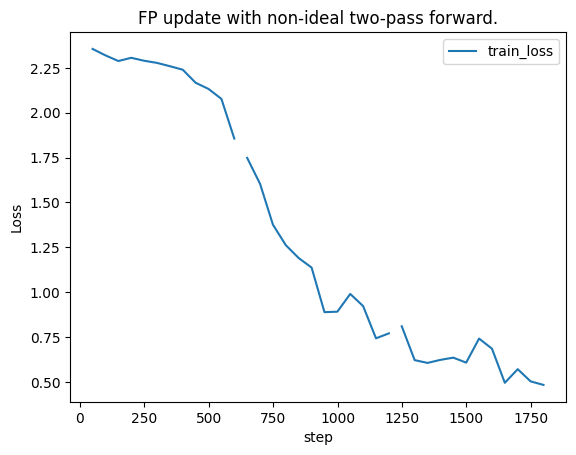

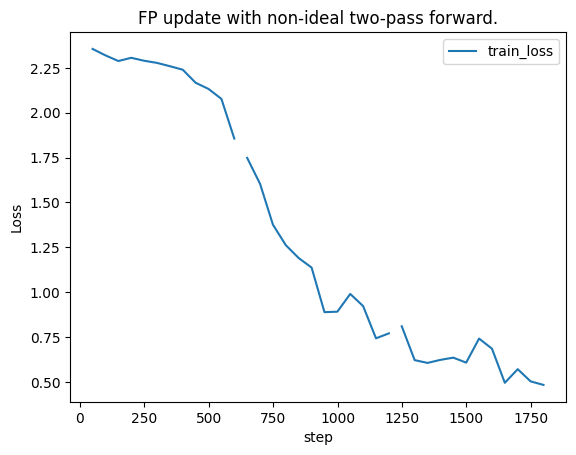

In [6]:
trainer, model = build_trainer(rpu_config, log="two_pass")
print(model)
fit_model(trainer, model)
plot_loss(trainer, "FP update with non-ideal two-pass forward.")

## Custom drift compensation

Aspects of the inference evaluation, such as the drift compensation, are also highly modular. Let's assume one wants to use a read-out multiple times to establish the drift baseline to average any read noise. We can create a new drift compensation class as follows:

In [7]:
from copy import deepcopy

from torch.autograd import no_grad
from torch import abs as torch_abs
from torch import clamp, Tensor, eye, tile

from aihwkit.inference.compensation.base import BaseDriftCompensation


class ReadNoiseGlobalDriftCompensation(BaseDriftCompensation):
    """Global drift compensation with mutiple read-outs.

    Uses a constant factor for compensating the drift.
    """
    def __init__(self, n_times: int = 1) -> None:
        self.n_times = n_times

    @no_grad()
    def readout(self, out_tensor: Tensor) -> Tensor:
        """Read outs the mean abs multiple times ."""
        return clamp(torch_abs(out_tensor).mean(), min=0.0001)

    @no_grad()
    def get_readout_tensor(self, in_size: int) -> Tensor:
        """Return the read-out tensor.

        Uses the n-times the set of one-hot vectors (eye).
        """
        return tile(eye(in_size), [self.n_times, 1])

    def __str__(self) -> str:
        return "{}(n_times={})".format(self.__class__.__name__, self.n_times)


In [8]:
rpu_config = deepcopy(rpu_config)
rpu_config.forward.out_noise = 0.2  # a lot of noise
rpu_config.drift_compensation = ReadNoiseGlobalDriftCompensation(n_times=10)
print(rpu_config)

TwoPassTorchInferenceRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(),
    forward=IOParameters(out_noise=0.2),
    backward=IOParameters(is_perfect=True),
    update=UpdateParameters(pulse_type=PulseType.NONE),
    noise_model=PCMLikeNoiseModel(g_converter=SinglePairConductanceConverter(g_max=25.00, g_min=0.00), g_max=25.0, prog_coeff_g_max_reference=25.0, prog_coeff=[0.26348, 1.965, -1.1731], t_0=20.0, t_read=2.5e-07, prog_noise_scale=1.0, read_noise_scale=1.0, drift_scale=1.0, valid_kwargs=['custom_drift_model'], custom_drift_model=None),
    drift_compensation=ReadNoiseGlobalDriftCompensation(n_times=10),
    clip=WeightClipParameter(type=WeightClipType.NONE),
    remap=WeightRemapParameter(type=WeightRemapType.NONE),
    modifier=WeightModifierParameter(type=WeightModifierType.NONE),
    device=IdealDevice(),
    one_pass=False
)


Let's use the above trained weights and and construct a new model with the new dirft compensation and then drift the weights. Note that we here load the model from the previous section but keep the new `rpu_config` by setting `load_rpu_config=False` which turns off loading the `rpu_config` from the state dictionary and thus keeps the one we have used to define the model. 

In [13]:
trainer, new_model = build_trainer(rpu_config, log='drift')


new_model.analog_model.load_state_dict(model.analog_model.state_dict(),load_rpu_config=False, strict_rpu_config_check=False)

new_model.analog_model.eval()
new_model.analog_model.drift_analog_weights(t_inference=3600.0)   # one hour, drift compensation is done with multiple read outs

trainer.test(new_model, get_data_loaders(batch_size=100)[1])



Testing DataLoader 0: 100%|██████████| 100/100 [00:00<00:00, 104.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5156999826431274
        test_loss           1.3664789199829102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3664789199829102, 'test_acc': 0.5156999826431274}]

## Add a new Inference Noise Model

For chips used for inference only, the AIHWKit defined a phenomenological noise model that captured 1/f noise and drift of the non-volatile memeory devices. This noise model is typically based on real device measurements such as the [`PCMLikeNoiseModel`](https://aihwkit.readthedocs.io/en/latest/pcm_inference.html). Assume one wants to add a new noise model what fits better to the devices of a particular hardware under investigations. One can do this by simply derive a new class from the [`BaseNoiseModel`](https://aihwkit.readthedocs.io/en/latest/api/aihwkit.inference.noise.base.html#aihwkit.inference.noise.base.BaseNoiseModel) 

Let's assume as an example that we want to have a new noise model that has a very simply programming model (just adding Guassian noise) and a very simple state-independent drift without any variability. This can be defined as follows:  

In [10]:
from torch import randn_like, tensor
from aihwkit.inference.noise.base import BaseNoiseModel

class SimpleNVMNoiseModel(BaseNoiseModel):
    """Very simple noise model of a new material """

    def __init__(self,  nu=0.1, prog_std=0.1, **kwargs):
        super().__init__(**kwargs)
        self.nu = nu
        self.prog_std = prog_std  # in muS 

    def apply_programming_noise_to_conductance(self, g_target: Tensor) -> Tensor:
        """Apply programming noise to a target conductance Tensor. """
        g_prog = g_target + self.prog_std * randn_like(g_target)
        g_prog.clamp_(min=0.0)  # no negative conductances allowed
        return g_prog

    def generate_drift_coefficients(self, g_target: Tensor) ->Tensor:
        """Just constant nu"""
        return tensor(self.nu)
     
    def apply_drift_noise_to_conductance(self, g_prog, nu, t_inference) -> Tensor:
        """Apply drift up to the assumed inference time"""
        t_0 = 1  # assume 1 sec as drift reference
        t = t_inference + t_0
        if t <= t_0:
            return g_prog
        return g_prog * ((t / t_0) ** (-nu))
    
    def __str__(self) -> str:
        return (
            "{}(prog_std={}, nu={}, g_converter={})"
        ).format(  # type: ignore
            self.__class__.__name__,
            self.prog_std,
            self.nu,
            self.g_converter)
    

To use this noise model we can simply set it in the `rpu_config`. Let's again use the previous model in this example:  

In [11]:
from aihwkit.inference import GlobalDriftCompensation
from aihwkit.inference.noise.base import BaseNoiseModel
from aihwkit.inference.converter.conductance import SinglePairConductanceConverter

rpu_config = TorchInferenceRPUConfig(
    drift_compensation=GlobalDriftCompensation(),
    noise_model=SimpleNVMNoiseModel(
        prog_std=0.1, 
        nu=0.1, 
        g_converter=SinglePairConductanceConverter(g_max=25.)
    )
)
print(rpu_config)

TorchInferenceRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(),
    forward=IOParameters(),
    backward=IOParameters(is_perfect=True),
    update=UpdateParameters(pulse_type=PulseType.NONE),
    noise_model=SimpleNVMNoiseModel(prog_std=0.1, nu=0.1, g_converter=SinglePairConductanceConverter(g_max=25.00, g_min=0.00)),
    drift_compensation=GlobalDriftCompensation(),
    clip=WeightClipParameter(type=WeightClipType.NONE),
    remap=WeightRemapParameter(type=WeightRemapType.NONE),
    modifier=WeightModifierParameter(type=WeightModifierType.NONE),
    device=IdealDevice()
)


Note the we use the single pair conductance converter which converts the analog weight values into a (set of) conductance value matrices that are then passed to the noise model.   

In [12]:
trainer, new_model = build_trainer(rpu_config, log='simple_nvm_noise')

new_model.analog_model.load_state_dict(model.analog_model.state_dict(),load_rpu_config=False, strict_rpu_config_check=False)

new_model.analog_model.eval()
new_model.analog_model.drift_analog_weights(t_inference=3600.0)   # one hour

trainer.test(new_model, get_data_loaders(batch_size=100)[1])

Testing DataLoader 0: 100%|██████████| 100/100 [00:01<00:00, 94.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5268999934196472
        test_loss           1.3519585132598877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3519585132598877, 'test_acc': 0.5268999934196472}]